<a href="https://colab.research.google.com/github/PrashantDandriyal/Udacity-Introduction-to-TensorFlow/blob/master/Generalized_Transfer_Learning_with_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
!pip install tf-nightly-gpu
!pip install "tensorflow_hub==0.4.0"
!pip install -U tensorflow_datasets

Requirement already up-to-date: tensorflow_datasets in /usr/local/lib/python3.6/dist-packages (1.2.0)


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt

import tensorflow as tf
tf.enable_eager_execution()

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [0]:
import logging
import numpy as np
import PIL.Image as Image
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In the cell below you will download the Flowers dataset using TensorFlow Datasets. If you look at the [TensorFlow Datasets documentation](https://www.tensorflow.org/datasets/datasets#tf_flowers) you will see that the name of the Flowers dataset is `tf_flowers`. You can also see that this dataset is only split into a ALL set. You will therefore have to use `tfds.splits` to split this training set into to a `training_set` and a `validation_set`. Do a `[80, 20]` split such that 80 corresponds to the `training_set` and 20 to the `validation_set`. Then load the `tf_flowers` dataset using `tfds.load`. Make sure the `tfds.load` function uses the all the parameters you need, and also make sure it returns the dataset info, so we can retrieve information about the datasets.




In [47]:
splits = tfds.Split.ALL.subsplit(weighted=(80, 20))   #Focus on "ALL"

splits, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True, split = splits)

(train_examples, validation_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: Bad argument number for Name: 3, expecting 4
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: Bad argument number for Name: 3, expecting 4


# TODO: Print Information about the Dataset

Now that you have downloaded the dataset, use the dataset info to print the number of classes in the dataset, and also write some code that counts how many images we have in the training and validation sets. 

In [48]:
num_classes = info.features['label'].num_classes

num_training_examples = 0
num_validation_examples = 0

for example in train_examples:
  num_training_examples += 1

for example in validation_examples:
  num_validation_examples += 1

print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 2
Total Number of Training Images: 18622
Total Number of Validation Images: 4640 



The images in the Dogs vs. Cats dataset are not all the same size.

In [49]:
for i, example_image in enumerate(train_examples.take(3)):
  print("Image {} shape: {}".format(i+1, example_image[0].shape))

Image 1 shape: (500, 343, 3)
Image 2 shape: (375, 500, 3)
Image 3 shape: (375, 500, 3)


So we need to reformat all images to the resolution expected by MobileNet (224, 224).

The `.repeat()` and `steps_per_epoch` here is not required, but saves ~15s per epoch, since the shuffle-buffer only has to cold-start once.

In [50]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches      = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

## Download the classifier

Download the MobileNet model and create a Keras model from it.
MobileNet is expecting images of 224 $\times$ 224 pixels, in 3 color channels (RGB).

In [51]:
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

## To Decode the predictions

To see what our predicted_class is in the ImageNet dataset, download the ImageNet labels and fetch the row that the model predicted.

In [0]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

# Part 3: Do simple transfer learning with TensorFlow Hub

Let's now use TensorFlow Hub to do Transfer Learning.

With transfer learning we reuse parts of an already trained model and change the final layer, or several layers, of the model, and then retrain those layers on our own dataset.

In addition to complete models, TensorFlow Hub also distributes models without the last classification layer. These can be used to easily do transfer learning. We will continue using MobileNet v2 because in later parts of this course, we will take this model and deploy it on a mobile device using [TensorFlow Lite](https://www.tensorflow.org/lite). Any [image feature vector URL from tfhub.dev](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) would work here.

We'll also continue to use the Dogs vs Cats dataset, so we will be able to compare the performance of this model against the ones we created from scratch earlier.

Note that we're calling the partial model from TensorFlow Hub (without the final classification layer) a `feature_extractor`. The reasoning for this term is that it will take the input all the way to a layer containing a number of features. So it has done the bulk of the work in identifying the content of an image, except for creating the final probability distribution. That is, it has extracted the features of the image.

### TODO: Create a Feature Extractor

In [0]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

#OPTIONAL*******************************

Let's run a batch of images through this, and see the final shape. 32 is the number of images, and 1280 is the number of neurons in the last layer of the partial model from TensorFlow Hub.

In [54]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['Egyptian cat', 'black-and-tan coonhound', 'Great Pyrenees',
       'Irish setter', 'flat-coated retriever', 'Egyptian cat',
       'Siamese cat', 'Great Dane', 'Walker hound', 'tabby',
       'Egyptian cat', 'Leonberg', 'Staffordshire bullterrier',
       'Rhodesian ridgeback', 'kelpie', 'Egyptian cat', 'tabby',
       'Egyptian cat', 'beagle', 'tabby', 'Rottweiler', 'Boston bull',
       'Egyptian cat', 'white wolf', 'Pembroke', 'Lhasa', 'Egyptian cat',
       'Persian cat', 'toy terrier', 'Rhodesian ridgeback', 'tabby',
       'Egyptian cat'], dtype='<U30')

In [55]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


Freeze the variables in the feature extractor layer, so that the training only modifies the final classifier layer.

In [0]:
feature_extractor.trainable = False

## Attach a classification head

Now wrap the hub layer in a `tf.keras.Sequential` model, and add a new classification layer.

In [57]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(2, activation='softmax')
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_5 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


## Train the model

We now train this model like any other, by first calling `compile` followed by `fit`.

In [58]:
model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

EPOCHS = 6
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
582/582 [==============================] - 76s 131ms/step - loss: 0.2345 - acc: 0.9375 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/6
582/582 [==============================] - 69s 119ms/step - loss: 0.1843 - acc: 0.9593 - val_loss: 0.1919 - val_acc: 0.9569
Epoch 3/6
582/582 [==============================] - 70s 120ms/step - loss: 0.1756 - acc: 0.9638 - val_loss: 0.1904 - val_acc: 0.9586
Epoch 4/6
582/582 [==============================] - 70s 120ms/step - loss: 0.1704 - acc: 0.9659 - val_loss: 0.1898 - val_acc: 0.9582
Epoch 5/6
582/582 [==============================] - 70s 120ms/step - loss: 0.1667 - acc: 0.9672 - val_loss: 0.1897 - val_acc: 0.9584
Epoch 6/6
582/582 [==============================] - 70s 120ms/step - loss: 0.1637 - acc: 0.9686 - val_loss: 0.1896 - val_acc: 0.9586


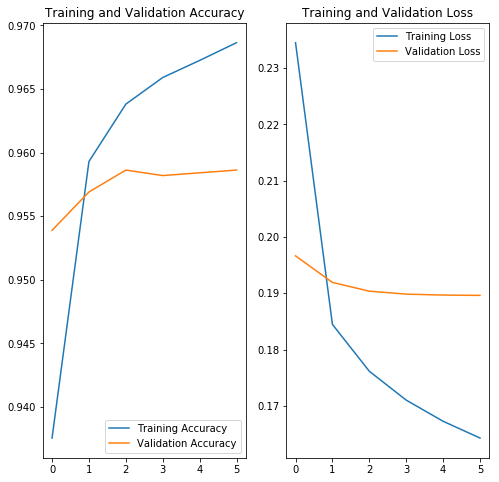

In [59]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Check the predictions

To redo the plot from before, first get the ordered list of class names.

In [60]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

Run the image batch through the model and convert the indices to class names.

In [61]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['cat', 'dog', 'dog', 'dog', 'dog', 'cat', 'cat', 'dog', 'dog',
       'cat', 'cat', 'dog', 'dog', 'dog', 'dog', 'cat', 'cat', 'cat',
       'dog', 'cat', 'dog', 'cat', 'cat', 'dog', 'dog', 'dog', 'cat',
       'cat', 'dog', 'dog', 'cat', 'cat'], dtype='<U3')

In [62]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [0 1 1 1 1 0 0 1 1 0 0 1 1 1 1 0 0 0 1 0 1 0 0 1 1 1 0 0 1 1 0 0]
Predicted labels:  [0 1 1 1 1 0 0 1 1 0 0 1 1 1 1 0 0 0 1 0 1 0 0 1 1 1 0 0 1 1 0 0]


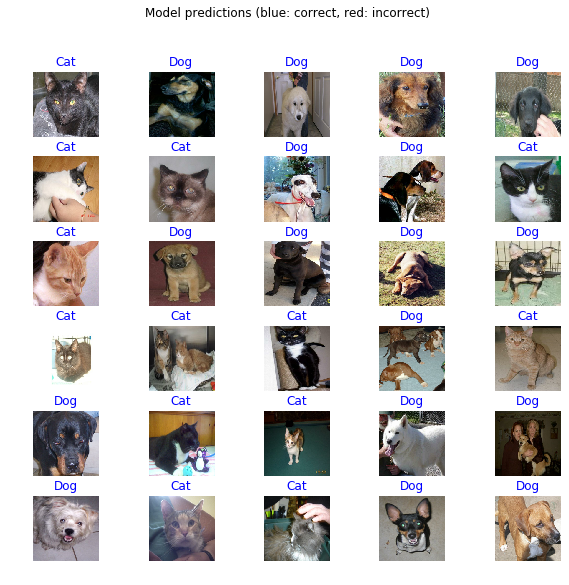

In [63]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")